In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install numpy
# %pip install scikit-learn
# %pip install xgboost

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from xgboost import XGBClassifier
from sklearn.decomposition import PCA, KernelPCA

In [3]:
class Flags:
    KEEP_TAXONOMY = False
    OMIT_ABSENT = True
    DRAW_PLOTS = False
    SAVE_PLOTS = False
    SEED = 0
    PRINT_FOLDS = False

In [4]:
class Util:
    binary_target = None
    kfold = None
    folds = None

### Visualization and Data Exploration

In [5]:
data = pd.read_csv( '../data/data_1.csv' )
print( 'Bacteria:', data.shape[0] )
print( 'Patients:', data.shape[1] )
data.head()

Bacteria: 5619
Patients: 61


,Taxonomy,A3,A5,A6,A9,A31,A51,A52,A53,A54,...,B120,B127,B132,B141,B142,B143,B152,B156,B158,B164
0,g__Faecalibacterium;s__Faecalibacterium prausn...,4988,5060,2905,5745,4822,3889,4646,6337,5064,...,4471,5868,6561,4910,4492,2812,5303,4205,3430,4563
1,g__Hungatella;s__Hungatella hathewayi,5803,5612,4109,1432,2652,4175,3891,894,4903,...,2126,4429,2598,4222,4925,5753,1261,1822,2478,4868
2,g__Clostridium;s__uncultured Clostridium sp.,3793,2795,1355,5558,5383,3505,5541,4429,4121,...,4085,6041,6188,3960,4403,2841,2746,3808,3856,3211
3,g__Butyricimonas;s__Butyricimonas virosa,64,1385,725,1553,40,53,33,175,58,...,2065,21,27,55,35,8,884,13,3,218
4,g__Alistipes;s__Alistipes indistinctus,15,20,723,620,3261,43,83,37,43,...,90,22,30,1027,2641,4,1587,2223,6,1473


In [6]:
data = data.drop( 'Taxonomy', axis = 1 ).T.rename_axis( 'Patient', axis = 1 )
if Flags.KEEP_TAXONOMY:
    data.columns = pd.read_csv( '../data/data_1.csv' )[ 'Taxonomy' ]
if Flags.OMIT_ABSENT:
    data.drop( columns = data.columns[ data.sum() == 0 ], inplace = True )
data.head()

Patient,0,1,2,3,4,5,6,7,8,9,...,5447,5448,5449,5450,5451,5452,5453,5454,5455,5456
A3,4988,5803,3793,64,15,100,2119,12,453,1266,...,0,0,0,0,0,0,0,0,0,0
A5,5060,5612,2795,1385,20,29,1230,24,691,1682,...,0,0,0,0,0,0,0,0,0,0
A6,2905,4109,1355,725,723,11,1322,1,2278,43,...,0,0,0,0,0,0,0,0,0,0
A9,5745,1432,5558,1553,620,1320,2675,44,107,1726,...,0,0,0,0,0,0,0,0,1,0
A31,4822,2652,5383,40,3261,51,1470,26,342,1804,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def define_binary_target():
    target = data.index.to_list()
    Util.binary_target = np.array( [ 0 if t.startswith( 'A' ) else 1 for t in target ] )
    Util.binary_target

define_binary_target()
print( Util.binary_target )

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [8]:
def most_correlated_taxonomy( width ):
    x = pd.concat( [ data[:10], data[30:40] ] )
    x = x.iloc[:, ::20]
    corrm = x.corr()
    for i in corrm:
        sorted = corrm[i].sort_values( ascending = False, key = lambda x: abs(x) )
        print( i )
        print( { sorted.index[j]: sorted[j].item() for j in range( 1, width+1 ) } )
        print()

if Flags.KEEP_TAXONOMY:
    most_correlated_taxonomy( 2 )

In [9]:
def draw_boxplot():
    plt.figure( figsize = ( 150, 10 ) )
    plt.boxplot( data.iloc[ :, :100 ] )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/boxplot.png", bbox_inches = 'tight', dpi = 100 )

if Flags.DRAW_PLOTS:
    draw_boxplot()

In [10]:
def draw_heatmaps( samples: int, size: int, filter: float ):
    data_subset = data.sample( axis = 1, n = samples )
    a_group = data_subset[:30]
    b_group = data_subset[30:]
    a_corr = a_group.corr()
    a_filtered_corr = a_corr[ a_corr.abs() >= filter ]
    b_corr = b_group.corr()
    b_filtered_corr = b_corr[ b_corr.abs() >= filter ]

    plt.figure( figsize = ( size, size ) )
    sns.heatmap( a_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
    plt.title( f'A group filtered abs(corr) >= { filter }, { samples } random' )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/a_filtered.png", bbox_inches = 'tight', dpi = 100 )
    plt.show()

    plt.figure( figsize = ( size, size ) )
    sns.heatmap( b_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
    plt.title( f'B group filtered abs(corr) >= { filter }, { samples } random' )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/b_filtered.png", bbox_inches = 'tight', dpi = 100 )
    plt.show()

    plt.figure( figsize = ( size, size ) )
    sns.heatmap( a_filtered_corr - b_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
    plt.title( f'Correlation difference: A - B' )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/corr_diff.png", bbox_inches = 'tight', dpi = 100 )
    plt.show()

if Flags.DRAW_PLOTS:
    draw_heatmaps( 5, 5, 0.2 )

### Model Classification

In [11]:
def find_most_important_features( print_n: int ):
    disease_train, disease_test, disease_y_train, disease_y_test = train_test_split( data, Util.binary_target, test_size = 0.2, shuffle = True, random_state = 0 )   
    print( disease_y_train.sum() )
    print( disease_test.shape )

    random_forest = RandomForestClassifier( n_estimators = 200, criterion = 'gini', random_state = Flags.SEED, max_features = 'sqrt' )
    random_forest.fit( disease_train, disease_y_train )

    most_important = sorted( list( enumerate( random_forest.feature_importances_ ) ), key = lambda k: -k[1] )
    print( most_important[:print_n] )
    print( data.columns[ [ k[0] for k in most_important[:print_n] ] ] )

find_most_important_features( 5 )

25
(12, 5457)
[(338, np.float64(0.017338721222504586)), (157, np.float64(0.017096823316317837)), (349, np.float64(0.014424373146452842)), (377, np.float64(0.013656671839795693)), (379, np.float64(0.013472991204844704))]
Index([338, 157, 349, 377, 379], dtype='int64', name='Patient')


In [12]:
Util.kfold = StratifiedKFold( n_splits = 10, shuffle = True, random_state = Flags.SEED )
Util.folds = enumerate( Util.kfold.split( data, Util.binary_target ) )

In [13]:
def run_classifier( data, target, model, name, kfold, folds ):
    roc_auc_scores = []
    folds = enumerate( kfold.split( data, target ) )
    for fold, ( train, test ) in folds:
        x_train, y_train = data.iloc[train], target[train]
        x_test, y_test = data.iloc[test], target[test]

        model.fit( x_train, y_train )
        y_pred = model.predict( x_test )

        roc_auc = roc_auc_score( y_test, y_pred )
        roc_auc_scores.append( roc_auc )

        if Flags.PRINT_FOLDS:
            print( f'Fold {fold}:\n{x_train.shape} {x_test.shape}\nROC AUC: {roc_auc:.2f}\n' )

    roc_auc_scores = np.array( roc_auc_scores )
    print( f'[{name}] min: %.2f, max: %.2f, avg %.2f' % ( roc_auc_scores.min(), roc_auc_scores.max(), roc_auc_scores.mean() ) )

In [14]:
run_classifier( data, Util.binary_target, RandomForestClassifier( n_estimators = 200, criterion = 'gini', random_state = Flags.SEED, max_features = 'sqrt' ), 'Random Forest', Util.kfold, Util.folds )

[Random Forest] min: 0.50, max: 1.00, avg 0.83


In [15]:
if Flags.KEEP_TAXONOMY:
    print( 'XGBClassifier is not compatible with Taxonomy strings. Please set KEEP_TAXONOMY to false.' )
else:
    run_classifier( data, Util.binary_target, XGBClassifier( random_state = Flags.SEED, n_jobs = 4 ), "XGBClassifier", Util.kfold, Util.folds )

[XGBClassifier] min: 0.50, max: 1.00, avg 0.90


In [16]:
run_classifier( data, Util.binary_target, LinearDiscriminantAnalysis(), "LDA", Util.kfold, Util.folds )

[LDA] min: 0.50, max: 1.00, avg 0.87


### Reduce Dimensionality

,0,1,2,3,4
0,-1966.416167,1644.254524,-338.803709,-1676.839289,368.094856
1,-1005.299304,887.174426,189.480766,-1605.801733,772.563941
2,-4122.225991,-731.624149,1149.100052,-213.958291,-31.256809
3,4691.930969,-176.299502,-365.763105,-200.030581,-352.969219
4,1221.806830,-455.702035,1290.161286,1212.948981,1464.547986


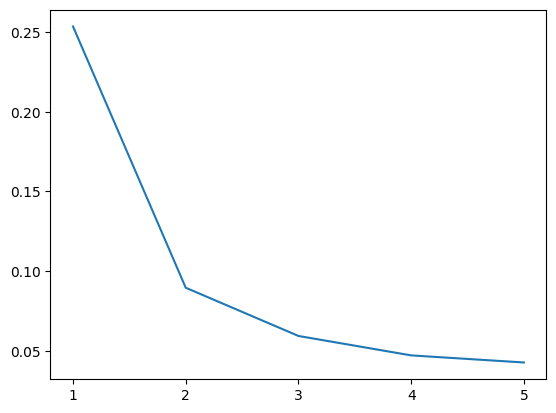

In [112]:
pca = PCA( n_components = 5 )
pca.fit( data )
reduced_data = pca.transform( data )
reduced_data_pd = pd.DataFrame( reduced_data )
plt.plot( [str(i+1) for i in range(5)], pca.explained_variance_ratio_ )
reduced_data_pd.head()

In [118]:
run_classifier( reduced_data_pd, Util.binary_target, RandomForestClassifier( n_estimators = 200, criterion = 'gini', random_state = Flags.SEED, max_features = 'sqrt' ), 'PCA + Random Forest', Util.kfold, Util.folds )

[PCA + Random Forest] min: 0.33, max: 1.00, avg 0.63


In [119]:
if Flags.KEEP_TAXONOMY:
    print( 'XGBClassifier is not compatible with Taxonomy strings. Please set KEEP_TAXONOMY to false.' )
else:
    run_classifier( reduced_data_pd, Util.binary_target, XGBClassifier( random_state = Flags.SEED, n_jobs = 4 ), "PCA + XGBClassifier", Util.kfold, Util.folds )

[PCA + XGBClassifier] min: 0.33, max: 1.00, avg 0.62


In [120]:
run_classifier( reduced_data_pd, Util.binary_target, LinearDiscriminantAnalysis(), "PCA + LDA", Util.kfold, Util.folds )

[PCA + LDA] min: 0.50, max: 1.00, avg 0.70
